# Convolution Neural Net (CNN)
to detect apples

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import modules.cosmos_functions as cf

import pprint
import random
import torch
import torchvision
import torch.nn.functional as F

import torchvision.transforms as T
import wandb
import torch.optim as optim
from datetime import datetime
from os import listdir, path
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from tqdm import tqdm

from torchvision import models
from torchvision.models import resnet18, ResNet18_Weights

In [2]:
# set the device

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
x = torch.ones(1, device=device)

print(f"Device is '{device}' Thus a tensor will look like this: {x}")

Device is 'mps' Thus a tensor will look like this: tensor([1.], device='mps:0')


In [3]:
# function to show the images




def show_batch(train_d, val_d):
    # Get a batch of data from the DataLoader
    data_train = next(iter(train_d))
    data_val = next(iter(val_d))

    # Set the savefig.bbox parameter to 'tight'
    plt.rcParams["savefig.bbox"] = 'tight'

    # Retrieve the first tensor and its corresponding label
    image_train = data_train[0][0]
    # image_test = data_test[0][0]
    image_val = data_val[0][0]
    label_train = data_train[1][0]
    # label_test = data_test[1][0]
    label_val = data_val[1][0]


    # Convert the image tensors to NumPy arrays and transpose the dimensions
    np_image_train = image_train.permute(1, 2, 0).numpy()
    # np_image_test = image_test.permute(1, 2, 0).numpy()
    np_image_val = image_val.permute(1, 2, 0).numpy()

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 2)

    # Display the image in the first subplot
    axes[0].imshow(np_image_train)
    axes[0].set_title(f'{label_train}, {image_train.shape}')

    # Display the image in the third subplot
    axes[1].imshow(np_image_val)
    axes[1].set_title(f'{label_val}, {image_val.shape}')

    # # Display the image in the second subplot
    # axes[2].imshow(np_image_test)
    # axes[2].set_title(f'{label_test}, {image_test.shape}')

    # Adjust spacing between subplots to prevent overlap
    fig.tight_layout()

    # Show the plot
    plt.show()


In [4]:
# function to determine accuracy 

def evaluate_accuracy(logits, y_true):
    # get index with the largest logit value PER OBSERVATION
    _, y_pred = torch.max(logits, dim=1)

    # calculate proportion of correct prediction
    correct_pred = (y_pred == y_true).float()  # PyCharm error Unresolved attribute reference 'float' for class 'bool'
    acc = correct_pred.sum() / len(correct_pred)

    return acc * 100

In [5]:
# function to train the model

def train(model, train_loader, val_loader, criterion, optimizer, n_epochs, model_file_name='model.pt',local_save_path='storage/data/generated'):
    # initialize container variable for model performance results per epoch
    history = {
        'n_epochs': n_epochs,
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }   

    # initialize tracker for minimum validation loss and maxiumum validation accuracy
    val_loss_min = np.Inf
    val_loss_epoch = 0
    val_acc_max = 0.0
    val_acc_epoch = 0
    best_results = {
        'val_loss_min': val_loss_min,
        'val_loss_epoch': val_loss_epoch,
        'val_acc_max': val_acc_max,
        'val_acc_epoch': val_acc_epoch
        }    

    model_file_name_loss = f'{str(model_file_name[:-3])}_loss.pt'
    model_file_name_acc = f'{str(model_file_name[:-3])}_acc.pt'
    final_model_file_name = f'{str(model_file_name[:-3])}_final.pt'
    locally_saved_path = local_save_path   

    file_data = { 
                'local_save_path' : locally_saved_path,
                'min_loss_file' : model_file_name_loss,
                'max_acc_file' : model_file_name_acc,
                'final_epoch_file' : final_model_file_name
                  }
    
    early_stopping_counter = 0

    model_safe_loss = f'../{locally_saved_path}/{model_file_name_loss}'
    model_safe_acc = f'../{locally_saved_path}/{model_file_name_acc}'
    model_safe_final = f'../{locally_saved_path}/{final_model_file_name}'

    # loop per epoch
    for epoch in tqdm(range(n_epochs)):
        
        # initialize tracker for training performance
        train_acc = 0
        train_loss = 0

        ###################
        # train the model #
        ###################

        # prepare model for training
        model.train()

        # loop for each batch
        for data, target in train_loader:
            # move data to device
            data, target = data.to(device), target.to(device)
            
            # STEP 1: clear gradients
            optimizer.zero_grad()
            # STEP 2: forward pass
            output = model(data)
            # STEP 3: calculate the loss
            loss = criterion(output, target)
            # STEP 4: backward pass
            loss.backward()
            # STEP 5: perform parameter update
            optimizer.step()
            # STEP 6: accumulate training loss and accuracy
            train_loss += loss.item() * data.size(0)
            acc = evaluate_accuracy(output, target)
            train_acc += acc.item() * data.size(0)

        ######################
        # validate the model #
        ######################

        # disable gradient calculation
        with torch.no_grad():
            # initialize tracker for validation performance
            val_acc = 0
            val_loss = 0

            # prepare model for evaluation
            model.eval()

            # loop for each batch
            for data, target in val_loader:
                # move data to device
                data, target = data.to(device), target.to(device)
                # STEP 1: forward pass
                output = model(data)
                # STEP 2: calculate the loss
                loss = criterion(output, target)
                # STEP 3: accumulate validation loss and accuracy
                val_loss += loss.item() * data.size(0)
                acc = evaluate_accuracy(output, target)
                val_acc += acc.item() * data.size(0)


        ####################
        # model evaluation #
        ####################

        # calculate average loss over an epoch
        train_loss /= len(train_loader.sampler)
        val_loss /= len(val_loader.sampler)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # calculate average accuracy over an epoch
        train_acc /= len(train_loader.sampler)
        val_acc /= len(val_loader.sampler)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # print training progress per epoch
        print(f'Epoch {epoch+1:03} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}')

        # save model if validation loss has decreased
        if val_loss <= val_loss_min:
            print(
                f'Validation loss decreased ({val_loss_min:.5f} --> {val_loss:.5f})  Saving model to {model_file_name}...')
            

            torch.save(model.state_dict(), model_safe_loss)
            val_loss_min = val_loss
            best_results['val_loss_min'] = val_loss_min
            best_results['val_loss_epoch'] = epoch+1
        
        # save model if validation accuracy has decreased
        if val_acc >= val_acc_max:
            print(
                f'Validation accuracy increased ({val_acc_max:.5f} --> {val_acc:.5f})  Saving model to {model_file_name}...')
            
            torch.save(model.state_dict(), model_safe_acc)
            val_acc_max = val_acc
            best_results['val_acc_max'] = val_acc_max
            best_results['val_acc_epoch'] = epoch+1
        

        # log metrics to wandb
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_acc": train_acc, "val_acc": val_acc})

    # save model at the end of training    
    torch.save(model.state_dict(), model_safe_final)

    results = best_results, history, file_data
    
    # return model performance history
    return results

In [6]:
# load the dataset
dataset_path = "../storage/images/apple_resized_128/Train/"
# transform and normalize the data
transform = T.Compose([
    T.ToTensor(),
    # # T.transforms.Resize((256, 256)),
    # # T.transforms.RandomCrop((224, 224)),
    # T.transforms.RandomHorizontalFlip(),
    # T.transforms.RandomVerticalFlip(),
    # T.transforms.RandomRotation(25),  # Randomly rotate the image by a maximum of 30 degrees
    # T.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Slightly change the image color
    # T.transforms.RandomGrayscale(p=0.1),  # Randomly convert the image to grayscale with a probability of 10%
    # T.transforms.RandomErasing(p=0.1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),  # Randomly erase rectangular patches of the image with a probability of 10%
    # # T.transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3),  # Randomly apply a perspective transformation to the image with a probability of 10%
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(dataset_path, transform=transform)


dataset.class_to_idx
pp = pprint.PrettyPrinter(indent=1)  # Create a PrettyPrinter instance with an indentation of 1 space
pp.pprint(dataset.class_to_idx)  # Use the pprint method to print the dictionary



{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}


torch.Size([3, 128, 128])
266
115


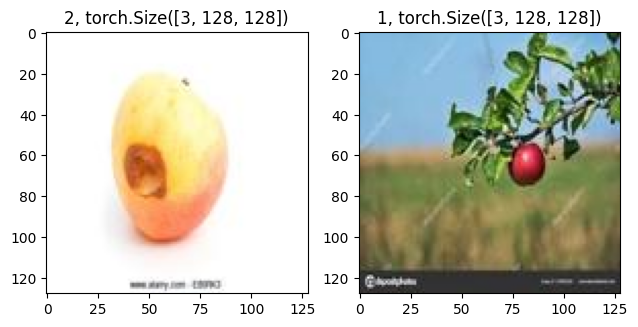

tensor([[[0.4588, 0.4627, 0.5647,  ..., 0.4784, 0.5176, 0.5804],
         [0.4784, 0.5059, 0.6078,  ..., 0.4824, 0.5804, 0.6980],
         [0.4706, 0.5216, 0.6157,  ..., 0.5255, 0.6902, 0.8471],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9804, 0.9804,  ..., 0.9922, 0.9922, 0.9922],
         [0.9882, 0.9882, 0.9882,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.4275, 0.4353, 0.5294,  ..., 0.5137, 0.5451, 0.5961],
         [0.4431, 0.4784, 0.5725,  ..., 0.5216, 0.6039, 0.7216],
         [0.4353, 0.4902, 0.5804,  ..., 0.5647, 0.7137, 0.8745],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.1843, 0.2196, 0.3608,  ..., 0.1490, 0.3843, 0.5373],
         [0.2118, 0.2667, 0.4118,  ..., 0.1843, 0.4627, 0.6667],
         [0.2196, 0.2980, 0.4275,  ..., 0.2941, 0.6039, 0.

In [7]:
# create the test, train and validation set and the dataloader

# setup split data 
dataset_size = len(dataset)
train_ratio = 0.7
val_ratio = 0.3



# Set the seed for the generator
seed = 42
generator = torch.Generator().manual_seed(seed)

# Calculate the number of samples for each split
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size 


# Split the dataset into train, validation, and test sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)


# Define the batch size for the DataLoader
batch_size = 32

# Create the DataLoader to load the dataset in batches
train_d = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2,)
val_d = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# print the shape of the 1st image in the dataset
print(train_dataset[0][0].shape)
print(len(train_dataset))
print(len(val_dataset))
# Show the 1st img in the dataset
show_batch(train_d, val_d)
print(train_dataset[0][0])
# Get the values of the middle 4x4 pixels of the 1st image in the dataset
print(train_dataset[0][0][:, 112:116, 112:116])

In [8]:
# import the resnet18 model

model = torch.hub.load(
    "pytorch/vision", "resnet18", weights="IMAGENET1K_V1")
num_ftrs = model.fc.in_features

# Here the size of each output sample is set to 4
model.fc = nn.Linear(num_ftrs, 4)

# Check if output size is correct
model.eval()


Using cache found in /Users/stephandekker/.cache/torch/hub/pytorch_vision_main


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# set the hyperparameters and the model

# hyperparameters
learning_rate = 0.001
epochs = 50
betas = None  # (0.9, 0.999)
momentum = 0.1
dropout = 0.1
total_epochs = 0  # legacy code
optchoice = 'adam'  # 'sgd' or 'adam'

# model parameters

# model = CNN(dropout=dropout) # Create the model
model.to(device) # set model to device

model.train() # set model to train mode

# optimizer
import torch.optim as optim
CrossEntropyLossCriterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(myresnetmodel.parameters(), lr=mylearnrate, momentum=mymomentum)
if optchoice == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print('optimizer = Adam')
elif optchoice  == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    print('optimizer = sgd')

# loss function
criterion = nn.CrossEntropyLoss()   # Define the loss function  
 
 # set the loaders to the correct names for the training loop
train_loader = train_d
val_loader = val_d

# set epochloss to empty list
epoch_loss = []
# create dictionairies for the hyperparameters and model parameters

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
userAccountID = cf.settings['userAccountID']
saveFileName = f'{timestamp}_{userAccountID}.pt'

hyperparameters = { 'saveFileName': saveFileName, 'learning_rate' : learning_rate, 'epochs' : epochs, 'momentum' : momentum, 'betas' : betas, 'dropout' : dropout}
model_parameters = { 'model' : 'resnet18', 'optimizer' : optchoice, 'criterion' : 'CrossEntropyLoss'}  # 'model' : model, 'optimizer' : optimizer, 'criterion' : criterion
parameters = {**hyperparameters, **model_parameters}    # merge the two dictionairies
pp = pprint.PrettyPrinter(indent=1)  


pp.pprint(f'parameters: {parameters}')
# the training loop


# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="resnet18_128x128_tests",
    
    # track hyperparameters and run metadata
    config= parameters
)

history = train(
    model, train_loader, val_loader, criterion, optimizer, n_epochs=epochs,
    model_file_name=saveFileName
)

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

print()
print(f'best results: {history[0]}')
print()
print(f'alot is: {history[1]}')
print()
print(f'save path = {history[2]}')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


optimizer = Adam
("parameters: {'saveFileName': '20230608-233306_pinky.pt', 'learning_rate': "
 "0.001, 'epochs': 50, 'momentum': 0.1, 'betas': None, 'dropout': 0.1, "
 "'model': 'resnet18', 'optimizer': 'adam', 'criterion': 'CrossEntropyLoss'}")


wandb: Currently logged in as: 1021548 (teamnan). Use `wandb login --relogin` to force relogin


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 1.26592 | Val Loss: 4.10450 | Train Acc: 62.78 | Val Acc: 66.96
Validation loss decreased (inf --> 4.10450)  Saving model to 20230608-233306_pinky.pt...
Validation accuracy increased (0.00000 --> 66.95652)  Saving model to 20230608-233306_pinky.pt...


  2%|▏         | 1/50 [00:24<20:05, 24.60s/it]

Epoch 002 | Train Loss: 0.55759 | Val Loss: 0.91485 | Train Acc: 83.46 | Val Acc: 74.78
Validation loss decreased (4.10450 --> 0.91485)  Saving model to 20230608-233306_pinky.pt...
Validation accuracy increased (66.95652 --> 74.78261)  Saving model to 20230608-233306_pinky.pt...


  6%|▌         | 3/50 [01:11<18:40, 23.84s/it]

Epoch 003 | Train Loss: 0.30547 | Val Loss: 1.36994 | Train Acc: 90.60 | Val Acc: 66.09
Epoch 004 | Train Loss: 0.16148 | Val Loss: 0.67948 | Train Acc: 94.74 | Val Acc: 77.39
Validation loss decreased (0.91485 --> 0.67948)  Saving model to 20230608-233306_pinky.pt...
Validation accuracy increased (74.78261 --> 77.39130)  Saving model to 20230608-233306_pinky.pt...


 10%|█         | 5/50 [01:59<17:49, 23.76s/it]

Epoch 005 | Train Loss: 0.17439 | Val Loss: 0.72791 | Train Acc: 93.98 | Val Acc: 83.48
Validation accuracy increased (77.39130 --> 83.47826)  Saving model to 20230608-233306_pinky.pt...


 12%|█▏        | 6/50 [02:22<17:23, 23.71s/it]

Epoch 006 | Train Loss: 0.10398 | Val Loss: 0.49051 | Train Acc: 95.49 | Val Acc: 83.48
Validation loss decreased (0.67948 --> 0.49051)  Saving model to 20230608-233306_pinky.pt...


 14%|█▍        | 7/50 [02:46<17:02, 23.79s/it]

Epoch 007 | Train Loss: 0.08914 | Val Loss: 0.52544 | Train Acc: 97.74 | Val Acc: 83.48


 16%|█▌        | 8/50 [03:10<16:40, 23.81s/it]

Epoch 008 | Train Loss: 0.06321 | Val Loss: 0.53357 | Train Acc: 98.87 | Val Acc: 83.48


 18%|█▊        | 9/50 [03:34<16:14, 23.76s/it]

Epoch 009 | Train Loss: 0.07336 | Val Loss: 0.64324 | Train Acc: 97.37 | Val Acc: 80.87


 20%|██        | 10/50 [03:58<15:49, 23.75s/it]

Epoch 010 | Train Loss: 0.05419 | Val Loss: 0.67062 | Train Acc: 97.74 | Val Acc: 84.35
Validation accuracy increased (83.47826 --> 84.34783)  Saving model to 20230608-233306_pinky.pt...


 22%|██▏       | 11/50 [04:21<15:23, 23.68s/it]

Epoch 011 | Train Loss: 0.16807 | Val Loss: 1.06401 | Train Acc: 96.24 | Val Acc: 68.70


 24%|██▍       | 12/50 [04:45<15:01, 23.72s/it]

Epoch 012 | Train Loss: 0.12154 | Val Loss: 0.52340 | Train Acc: 95.86 | Val Acc: 81.74


 26%|██▌       | 13/50 [05:09<14:37, 23.72s/it]

Epoch 013 | Train Loss: 0.14583 | Val Loss: 0.94265 | Train Acc: 93.61 | Val Acc: 81.74


 28%|██▊       | 14/50 [05:33<14:15, 23.77s/it]

Epoch 014 | Train Loss: 0.13597 | Val Loss: 0.74484 | Train Acc: 94.36 | Val Acc: 83.48


 30%|███       | 15/50 [05:56<13:51, 23.77s/it]

Epoch 015 | Train Loss: 0.12742 | Val Loss: 1.13770 | Train Acc: 95.86 | Val Acc: 78.26


 32%|███▏      | 16/50 [06:20<13:26, 23.71s/it]

Epoch 016 | Train Loss: 0.06511 | Val Loss: 0.68845 | Train Acc: 98.50 | Val Acc: 82.61


 34%|███▍      | 17/50 [06:44<13:02, 23.70s/it]

Epoch 017 | Train Loss: 0.11069 | Val Loss: 0.47416 | Train Acc: 96.62 | Val Acc: 84.35
Validation loss decreased (0.49051 --> 0.47416)  Saving model to 20230608-233306_pinky.pt...
Validation accuracy increased (84.34783 --> 84.34783)  Saving model to 20230608-233306_pinky.pt...


 36%|███▌      | 18/50 [07:07<12:38, 23.69s/it]

Epoch 018 | Train Loss: 0.06823 | Val Loss: 0.66739 | Train Acc: 97.37 | Val Acc: 80.00


 38%|███▊      | 19/50 [07:31<12:13, 23.66s/it]

Epoch 019 | Train Loss: 0.04858 | Val Loss: 0.71139 | Train Acc: 98.12 | Val Acc: 80.87


 40%|████      | 20/50 [07:54<11:49, 23.65s/it]

Epoch 020 | Train Loss: 0.03921 | Val Loss: 0.57149 | Train Acc: 98.12 | Val Acc: 86.96
Validation accuracy increased (84.34783 --> 86.95652)  Saving model to 20230608-233306_pinky.pt...


 42%|████▏     | 21/50 [08:18<11:24, 23.61s/it]

Epoch 021 | Train Loss: 0.03243 | Val Loss: 0.60276 | Train Acc: 98.87 | Val Acc: 85.22


 44%|████▍     | 22/50 [08:42<11:00, 23.59s/it]

Epoch 022 | Train Loss: 0.05538 | Val Loss: 0.63193 | Train Acc: 98.87 | Val Acc: 85.22


 46%|████▌     | 23/50 [09:05<10:37, 23.63s/it]

Epoch 023 | Train Loss: 0.10662 | Val Loss: 0.87637 | Train Acc: 95.86 | Val Acc: 79.13


 48%|████▊     | 24/50 [09:29<10:17, 23.76s/it]

Epoch 024 | Train Loss: 0.12847 | Val Loss: 0.75831 | Train Acc: 95.86 | Val Acc: 83.48


 50%|█████     | 25/50 [09:53<09:53, 23.74s/it]

Epoch 025 | Train Loss: 0.26277 | Val Loss: 2.89245 | Train Acc: 94.36 | Val Acc: 51.30


 52%|█████▏    | 26/50 [10:17<09:28, 23.69s/it]

Epoch 026 | Train Loss: 0.21070 | Val Loss: 2.00947 | Train Acc: 91.73 | Val Acc: 55.65


 54%|█████▍    | 27/50 [10:40<09:04, 23.65s/it]

Epoch 027 | Train Loss: 0.22289 | Val Loss: 1.71375 | Train Acc: 93.23 | Val Acc: 60.00


 56%|█████▌    | 28/50 [11:04<08:40, 23.65s/it]

Epoch 028 | Train Loss: 0.15405 | Val Loss: 0.70688 | Train Acc: 93.98 | Val Acc: 77.39
Epoch 029 | Train Loss: 0.08996 | Val Loss: 0.41654 | Train Acc: 96.99 | Val Acc: 87.83
Validation loss decreased (0.47416 --> 0.41654)  Saving model to 20230608-233306_pinky.pt...
Validation accuracy increased (86.95652 --> 87.82609)  Saving model to 20230608-233306_pinky.pt...


 60%|██████    | 30/50 [11:51<07:54, 23.75s/it]

Epoch 030 | Train Loss: 0.05339 | Val Loss: 0.56594 | Train Acc: 98.12 | Val Acc: 82.61


 62%|██████▏   | 31/50 [12:15<07:30, 23.71s/it]

Epoch 031 | Train Loss: 0.03672 | Val Loss: 0.74952 | Train Acc: 98.87 | Val Acc: 79.13


 64%|██████▍   | 32/50 [12:39<07:07, 23.76s/it]

Epoch 032 | Train Loss: 0.01760 | Val Loss: 0.65181 | Train Acc: 99.62 | Val Acc: 83.48


 66%|██████▌   | 33/50 [13:03<06:44, 23.77s/it]

Epoch 033 | Train Loss: 0.01227 | Val Loss: 0.54676 | Train Acc: 100.00 | Val Acc: 85.22


 68%|██████▊   | 34/50 [13:26<06:19, 23.72s/it]

Epoch 034 | Train Loss: 0.04283 | Val Loss: 0.65860 | Train Acc: 98.87 | Val Acc: 83.48


 70%|███████   | 35/50 [13:50<05:55, 23.67s/it]

Epoch 035 | Train Loss: 0.04942 | Val Loss: 1.37675 | Train Acc: 98.50 | Val Acc: 62.61


 72%|███████▏  | 36/50 [14:14<05:32, 23.76s/it]

Epoch 036 | Train Loss: 0.05747 | Val Loss: 0.65087 | Train Acc: 97.37 | Val Acc: 82.61


 74%|███████▍  | 37/50 [14:37<05:07, 23.69s/it]

Epoch 037 | Train Loss: 0.07519 | Val Loss: 0.52326 | Train Acc: 96.99 | Val Acc: 84.35


 76%|███████▌  | 38/50 [15:01<04:44, 23.68s/it]

Epoch 038 | Train Loss: 0.10315 | Val Loss: 0.64390 | Train Acc: 98.12 | Val Acc: 81.74


 78%|███████▊  | 39/50 [15:25<04:20, 23.69s/it]

Epoch 039 | Train Loss: 0.07115 | Val Loss: 0.46520 | Train Acc: 98.50 | Val Acc: 89.57
Validation accuracy increased (87.82609 --> 89.56522)  Saving model to 20230608-233306_pinky.pt...


 80%|████████  | 40/50 [15:48<03:56, 23.68s/it]

Epoch 040 | Train Loss: 0.04304 | Val Loss: 0.46838 | Train Acc: 98.50 | Val Acc: 88.70


 82%|████████▏ | 41/50 [16:12<03:33, 23.77s/it]

Epoch 041 | Train Loss: 0.02231 | Val Loss: 0.64366 | Train Acc: 99.62 | Val Acc: 85.22


 84%|████████▍ | 42/50 [16:36<03:10, 23.79s/it]

Epoch 042 | Train Loss: 0.01392 | Val Loss: 0.68678 | Train Acc: 99.25 | Val Acc: 83.48


 86%|████████▌ | 43/50 [17:00<02:45, 23.70s/it]

Epoch 043 | Train Loss: 0.01281 | Val Loss: 0.57666 | Train Acc: 99.62 | Val Acc: 85.22


 88%|████████▊ | 44/50 [17:24<02:22, 23.77s/it]

Epoch 044 | Train Loss: 0.01510 | Val Loss: 0.51645 | Train Acc: 99.25 | Val Acc: 86.96


 90%|█████████ | 45/50 [17:47<01:58, 23.71s/it]

Epoch 045 | Train Loss: 0.01199 | Val Loss: 0.47345 | Train Acc: 99.62 | Val Acc: 84.35


 92%|█████████▏| 46/50 [18:11<01:35, 23.77s/it]

Epoch 046 | Train Loss: 0.00572 | Val Loss: 0.47600 | Train Acc: 100.00 | Val Acc: 85.22


 94%|█████████▍| 47/50 [18:35<01:11, 23.73s/it]

Epoch 047 | Train Loss: 0.00889 | Val Loss: 0.49659 | Train Acc: 99.25 | Val Acc: 84.35


 96%|█████████▌| 48/50 [18:59<00:47, 23.95s/it]

Epoch 048 | Train Loss: 0.00939 | Val Loss: 0.56794 | Train Acc: 99.25 | Val Acc: 86.09


 98%|█████████▊| 49/50 [19:23<00:23, 23.86s/it]

Epoch 049 | Train Loss: 0.00818 | Val Loss: 0.58589 | Train Acc: 99.62 | Val Acc: 86.96


100%|██████████| 50/50 [19:46<00:00, 23.74s/it]

Epoch 050 | Train Loss: 0.01136 | Val Loss: 0.67712 | Train Acc: 99.25 | Val Acc: 83.48


train_acc,▁▅▆▇▇███▇▇▇▇█▇████▇▇▆▇▇▇█████▇██████████
train_loss,█▄▃▂▂▁▁▁▂▂▂▂▁▂▁▁▁▁▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_acc,▃▅▃▅▇▇▇▆▄▆▆▇▇▇▆▆▇▇▆▇▁▂▅█▆▇▇▇▇▇▆█▇▇▇▇▇▇▇▇
val_loss,█▂▃▁▁▁▁▁▂▁▂▂▂▁▁▂▁▁▂▂▄▃▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
train_acc,99.24812
train_loss,0.01136
val_acc,83.47826
val_loss,0.67712



best results: {'val_loss_min': 0.41654070615768435, 'val_loss_epoch': 29, 'val_acc_max': 89.56521739130434, 'val_acc_epoch': 39}

alot is: {'n_epochs': 50, 'train_loss': [1.2659188912327128, 0.5575865390605497, 0.30547488004641427, 0.1614808404356017, 0.17438784622608272, 0.10398138745834953, 0.08913930880844145, 0.06321070102372564, 0.07336251167370413, 0.05419177175464487, 0.16807121105660172, 0.12153783871939308, 0.1458321081516438, 0.13596866901655844, 0.12742307199571365, 0.06510569144012336, 0.11069464148547416, 0.06822788715362549, 0.048575898730441144, 0.03920698658864301, 0.03242878018199165, 0.05537624092758598, 0.1066195676873501, 0.12847283975522322, 0.26276740633455437, 0.2106990335803283, 0.22288843966964492, 0.15405369195666976, 0.0899561515316031, 0.05338636219949651, 0.03671725291086543, 0.01759625790479656, 0.012267961818024628, 0.04282722952670621, 0.049420901119036784, 0.05746529036537653, 0.07518575225669638, 0.10315230102243281, 0.07115362477803924, 0.04304014025

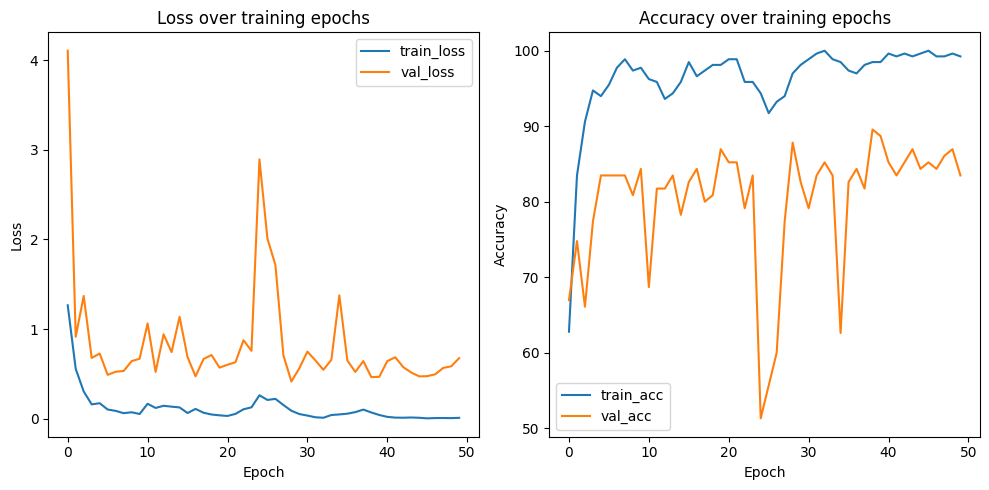

In [10]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the training and validation loss
axs[0].plot(history[1]['train_loss'], label='train_loss')
axs[0].plot(history[1]['val_loss'], label='val_loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss over training epochs')
axs[0].legend()

# Plot the training and validation accuracy
axs[1].plot(history[1]['train_acc'], label='train_acc')
axs[1].plot(history[1]['val_acc'], label='val_acc')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy over training epochs')
axs[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

In [11]:
# show the save paths from history
history

({'val_loss_min': 0.41654070615768435,
  'val_loss_epoch': 29,
  'val_acc_max': 89.56521739130434,
  'val_acc_epoch': 39},
 {'n_epochs': 50,
  'train_loss': [1.2659188912327128,
   0.5575865390605497,
   0.30547488004641427,
   0.1614808404356017,
   0.17438784622608272,
   0.10398138745834953,
   0.08913930880844145,
   0.06321070102372564,
   0.07336251167370413,
   0.05419177175464487,
   0.16807121105660172,
   0.12153783871939308,
   0.1458321081516438,
   0.13596866901655844,
   0.12742307199571365,
   0.06510569144012336,
   0.11069464148547416,
   0.06822788715362549,
   0.048575898730441144,
   0.03920698658864301,
   0.03242878018199165,
   0.05537624092758598,
   0.1066195676873501,
   0.12847283975522322,
   0.26276740633455437,
   0.2106990335803283,
   0.22288843966964492,
   0.15405369195666976,
   0.0899561515316031,
   0.05338636219949651,
   0.03671725291086543,
   0.01759625790479656,
   0.012267961818024628,
   0.04282722952670621,
   0.049420901119036784,
   0.0574

In [ ]:
# function to test the model
def test_model(model, datasetPath):
    model.eval()    

    # Load the test dataset
    dataset_path = datasetPath
    transform = T.Compose([
    T.ToTensor()
                )
])
    dataset = ImageFolder(dataset_path, transform=transform)
    test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    labels_dict = dataset.class_to_idx

    # Track the overall test accuracy and accuracy by each type of apple
    overall_correct = 0
    overall_total = 0
    normal_correct = 0
    normal_total = 0
    abnormal_correct = 0
    abnormal_total = 0

    # Initialize the confusion matrix
    num_classes = len(labels_dict)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    # Iterate over the test dataset
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)

        # Update accuracy counts
        overall_correct += (predicted == labels).sum().item()
        overall_total += labels.size(0)

        # Calculate accuracy for normal apples vs. abnormal apples
        normal_mask = labels == labels_dict['Normal_Apple']
        abnormal_mask = ~normal_mask
        normal_correct += (predicted[normal_mask] == labels[normal_mask]).sum().item()
        normal_total += normal_mask.sum().item()
        abnormal_correct += (predicted[abnormal_mask] == labels[abnormal_mask]).sum().item()
        abnormal_total += abnormal_mask.sum().item()

        # Update the confusion matrix
        for true_label, predicted_label in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
            confusion_matrix[true_label][predicted_label] += 1

    # Calculate overall accuracy
    overall_accuracy = overall_correct / overall_total

    # Calculate accuracy for normal apples and abnormal apples separately
    normal_accuracy = normal_correct / normal_total if normal_total != 0 else 0.0
    abnormal_accuracy = abnormal_correct / abnormal_total if abnormal_total != 0 else 0.0

    # Print overall accuracy
    print(f"Overall accuracy: {overall_accuracy:.4f}")

    # Print accuracy for normal apples and abnormal apples separately
    print(f"Normal Apple accuracy: {normal_accuracy:.4f}")
    print(f"Abnormal Apple accuracy: {abnormal_accuracy:.4f}")

    # Print the confusion matrix
    print()
    print(labels_dict)
    print("Confusion Matrix:")
    print(confusion_matrix)

save the data to azure cosmos NoSQL database


In [12]:
local_saved_path= list(history[2].values())[0]
model_file_name_loss = list(history[2].values())[1]
print(f'{list(history[2].values())[0]}/{list(history[2].values())[1]}')

model_file_name_loss= f'{list(history[2].values())[0]}/{list(history[2].values())[1]}'
print(model_file_name_loss)

storage/data/generated/20230608-233306_pinky_loss.pt
storage/data/generated/20230608-233306_pinky_loss.pt


# Azure Cosmos NoSQL db seems to refuse the size of the model file.

In [13]:
# save the model to cosmos db


import time

model_file_name_loss= f'../{list(history[2].values())[0]}/{list(history[2].values())[1]}'
model_file_name_acc = f'../{list(history[2].values())[0]}/{list(history[2].values())[2]}'
model_file_name_final = f'../{list(history[2].values())[0]}/{list(history[2].values())[3]}'
# model_file_name_loss= './20230605-103225_pinky_loss.pt' 
# model_file_name_acc = './20230605-103225_pinky_acc.pt'
# model_file_name_final = './20230605-103225_pinky_final.pt'
print(model_file_name_loss)
print(model_file_name_acc)
print(model_file_name_final)


pulled_loss = cf.save_data(parameters, history, )
time.sleep(2)
pulled_acc = cf.save_data(parameters, history)
time.sleep(2)
pulled_final = cf.save_data(parameters, history)

../storage/data/generated/20230608-233306_pinky_loss.pt
../storage/data/generated/20230608-233306_pinky_acc.pt
../storage/data/generated/20230608-233306_pinky_final.pt


TypeError: expected str, bytes or os.PathLike object, not dict

test


In [ ]:
print(pulled_final)

# WIP loader loads a wrong data type.